In [1]:
import tensorflow as tf
import utils
import os
import scipy
import keras.applications.vgg19 as vgg19
import keras.preprocessing.image as image_preprocessing
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
def preprocess_image(path):
  img = image_preprocessing.load_img(path, target_size=image_shape, interpolation='bilinear')
  img = image_preprocessing.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = vgg19.preprocess_input(img)
  assert img.shape == (1, *image_shape)
  return img

def deprocess_image(x):
  x = x.copy()
  x = x.reshape(image_shape)
  # Remove zero-center by mean pixel
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  # 'BGR'->'RGB'
  x = x[:, :, ::-1]
  x = np.clip(x, 0, 255).astype('uint8')
  return x

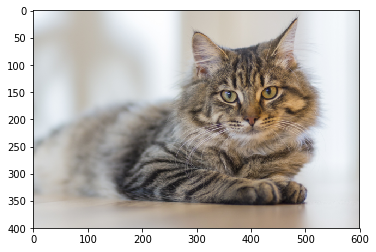

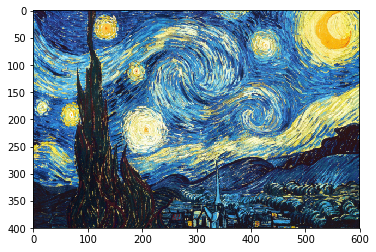

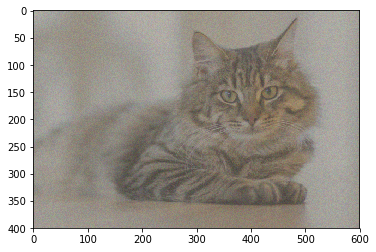

In [3]:
# image_shape = (300, 400, 3)
image_shape = (400, 600, 3)

content_image = preprocess_image("images/cat_large.jpg")
style_image = preprocess_image("images/starry_night_large.jpg")

noise_ratio = 0.6
noise_image = np.random.uniform(-20, 20, (1, *image_shape))
input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)

plt.imshow(deprocess_image(content_image))
plt.show()
plt.imshow(deprocess_image(style_image))
plt.show()
plt.imshow(deprocess_image(input_image))
plt.show()

In [4]:
input_tensor=tf.Variable(tf.zeros([1, *image_shape]))
model = vgg19.VGG19(include_top=False, weights='imagenet', input_tensor=input_tensor)

In [5]:
def compute_content_loss(a_C, a_G):
  m, n_H, n_W, n_C = a_G.shape.as_list()
  return tf.reduce_sum(tf.square(a_C - a_G)) / (4 * n_H * n_W * n_C)

def compute_style_loss(outputs, sess):
  style_loss = 0

  for output, coeff in outputs:
    a_S = sess.run(output)
    a_G = output

    layer_style_loss = compute_layer_style_loss(a_S, a_G)
    style_loss += coeff * layer_style_loss

  return style_loss

def compute_layer_style_loss(a_S, a_G):
  m, n_H, n_W, n_C = a_G.shape.as_list()
  a_S = tf.reshape(a_S, [n_H * n_W, n_C])
  a_G = tf.reshape(a_G, [n_H * n_W, n_C])
  GS = gram_matrix(a_S)
  GG = gram_matrix(a_G)
  assert GS.shape == (n_C, n_C) and GS.shape == GG.shape
  return tf.reduce_sum(tf.square(GS - GG)) / (4 * n_C ** 2 * (n_H * n_W) ** 2)
  
def gram_matrix(A):
  return tf.matmul(tf.transpose(A), A)

In [ ]:
content_layer = model.get_layer('block4_conv2')

style_layers = [
  ('block1_conv1', 0.2),
  ('block2_conv1', 0.2),
  ('block3_conv1', 0.2),
  ('block4_conv1', 0.2),
  ('block5_conv1', 0.2)
]

style_outputs = []
for (layer_name, coeff) in style_layers:
  layer = model.get_layer(layer_name)
  style_outputs.append((layer.output, coeff))
  
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  
  sess.run(input_tensor.assign(content_image))
  a_C = sess.run(content_layer.output)
  a_G = content_layer.output
  content_loss = compute_content_loss(a_C, a_G)
  
  sess.run(input_tensor.assign(style_image))
  style_loss = compute_style_loss(style_outputs, sess)

alpha = 10
beta = 40
# alpha = 0.025
# beta = 1.0

loss = alpha * content_loss + beta * style_loss

train = tf.train.AdamOptimizer(1.0).minimize(loss, var_list=[input_tensor])

step: 0, loss: 22335.59765625


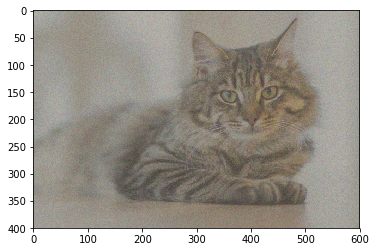

step: 10, loss: 19532.76171875


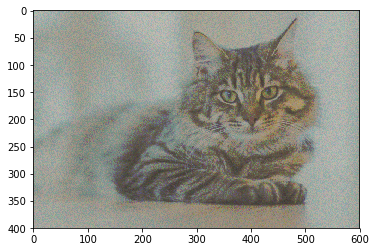

step: 20, loss: 17181.294921875


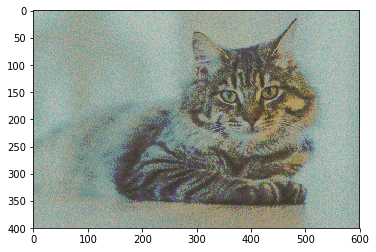

In [ ]:
n_steps = 100

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  sess.run(input_tensor.assign(input_image))
  
  for i in range(n_steps):
    sess.run([train])
    
    if i % 10 == 0:
      l, image = sess.run([loss, input_tensor])
      print('step: {}, loss: {}, image:'.format(i, l))
      plt.imshow(deprocess_image(image))
      plt.show()